In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/suicideClassification/Data/data.csv')

In [ ]:
data.head(10)

,Text,Ideation
0,A life without coffee is a life not worth livi...,0
1,Life without risks is not worth living.,0
2,Living your life in fear is a life not Worth l...,0
3,"Sometimes, I feel like I’m not worth living, I...",1
4,"There is no actual meaning to life, but it doe...",0
5,A life without chocolate is a life not worth l...,0
6,I guess I’m not worth living.,1
7,Life is not worth living without the one you love,0
8,My life is ruined. It's not worth living.,1
9,This lockdown proves a life with no sport is a...,0


In [ ]:
data.describe()

,Ideation
count,1285.000000
mean,0.715175
std,0.776281
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


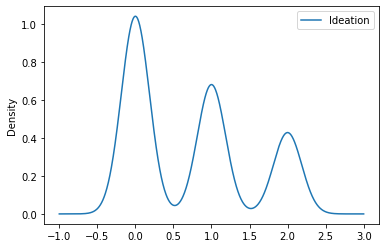

In [ ]:
densityPlot = data.plot.kde()

In [ ]:
# Clean the Data

"""
A utility function to remove punctuations from the text.

"""

def remove_punctuations(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


stop_words = set(stopwords.words('english'))

"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string

In [ ]:
data["Text"] = data["Text"].apply(lambda x: remove_punctuations(x))
data["Text"] = data["Text"].apply(lambda x: remove_nums(x))
data["Text"] = data["Text"].apply(lambda x: remove_URL(x))
data["Text"] = data["Text"].apply(lambda x: remove_html(x))
data["Text"] = data["Text"].apply(lambda x: remove_emoji(x))
data["Text"] = data["Text"].apply(lambda x: clean_stopwords(x))

data = data.sample(frac = 1).reset_index(drop=True).reset_index(drop = True)

data.head(10)

,Text,Ideation
0,wasnt illegal kill I would,0
1,take pigs india don’t need worthless live indi...,0
2,Last night came clean mother depression told h...,0
3,I wanna die I wanna die I wanna die Im broken,2
4,Late replies makes wanna kill,0
5,I feel unloved sad I wanna sleep forever,1
6,I well believe y’all follow people don’t like ...,0
7,My future bleak hope Suicide way,2
8,I don’t want I want die Always sad I’ll never ...,2
9,I really wanna die tonight,2


In [ ]:
X = data["Text"]
y = data["Ideation"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train

914     People say suicide selfish whats even selfish ...
707              every day literally bro I’m tired living
1088           I tried kill many decades ago Jesus healed
344                  If I kill know I enjoyed years earth
135                          When poor wake sleep forever
                              ...                        
1044    Telling kids emotions invalid incorrect leads ...
1095    I AM SO TIRED SO TIRED I JUST WANNA SLEEP FORE...
1130               I feel like I’m bad dream I never wake
860                     My coffee maker died suicide note
1126    Why care We know dont If smokers get depressed...
Name: Text, Length: 1028, dtype: object

In [ ]:
tf.random.set_seed(100)

vocab_size = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1028
max_length = 100

# Split Labels

temp = [x for x in data["Text"].tolist()]
train_sentences = temp[:training_size]
test_sentences = temp[training_size:]

temp2 = [x for x in data["Ideation"].tolist()]
train_labels = temp2[:training_size]
test_labels = temp2[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Convert to Numpy Array

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
"""
A utility function plot learning curves for the trained model.

"""

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
num_epochs = 100

history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_split = 0.2, \
                        callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1, steps_per_epoch = 1000)

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Epoch 1/100
1000/1000 [==============================] - 11s 11ms/step - loss: -386.2584 - accuracy: 0.6710 - val_loss: -271.0097 - val_accuracy: 0.4806
Epoch 2/100
1000/1000 [==============================] - 11s 11ms/step - loss: -437.6450 - accuracy: 0.7040 - val_loss: -302.3775 - val_accuracy: 0.4612
Epoch 3/100
1000/1000 [==============================] - 11s 11ms/step - loss: -465.4803 - accuracy: 0.7040 - val_loss: -320.2925 - val_accuracy: 0.4854
Epoch 4/100
 540/1000 [===============>..............] - ETA: 5s - loss: -574.0707 - accuracy: 0.6907

KeyboardInterrupt: ignored